# ENSF 444 Project Group 31



### Step 0: Import Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import ast
import warnings
warnings.filterwarnings('ignore')

### Step 1: Data Input

1. Download the tmdb_5000_movies.csv datset on Kaggle through this link:
https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata/data?select=tmdb_5000_movies.csv

1. Place the dataset file in the same directory as this Jupyer Notebook.
1. Run all of the cells sequentially.

In [39]:
data = pd.read_csv('tmdb_5000_movies.csv')
data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995.0,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2.787965e+09,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800.0
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285.0,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,9.610000e+08,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500.0
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647.0,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,8.806746e+08,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466.0
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026.0,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1.084939e+09,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106.0
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529.0,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,2.841391e+08,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124.0


### Step 2: Data Processing

In [40]:
print(data.isnull().sum()) #checking for null values in the dataset

budget                     0
genres                     9
homepage                3103
id                         9
keywords                   9
original_language          9
original_title             9
overview                  12
popularity                 9
production_companies       9
production_countries       9
release_date              10
revenue                    9
runtime                   11
spoken_languages           9
status                     9
tagline                  854
title                      9
vote_average               9
vote_count                 9
dtype: int64


In [41]:
# Handle missing values
data['runtime'].fillna(data['runtime'].median(), inplace=True)
data['release_date'].fillna('2000-01-01', inplace=True)

# Drop columns with many missing values or not relevant for prediction
data.drop(['homepage', 'tagline', 'keywords', 'production_companies', 
           'production_countries', 'spoken_languages'], axis=1, inplace=True)

# Drop remaining rows with missing values
data.dropna(inplace=True)

# Verify no more missing values
print("\nMissing values after cleaning:")
print(data.isnull().sum())


Missing values after cleaning:
budget               0
genres               0
id                   0
original_language    0
original_title       0
overview             0
popularity           0
release_date         0
revenue              0
runtime              0
status               0
title                0
vote_average         0
vote_count           0
dtype: int64


#### Parse JSON columns

In [42]:
# Parse JSON columns for genres
data['genres_list'] = data['genres'].apply(lambda x: [item['name'] for item in ast.literal_eval(x)])

# Create binary columns for top genres
top_genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Drama', 
              'Horror', 'Romance', 'Science Fiction', 'Thriller']
for genre in top_genres:
    data[genre] = data['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Extract temporal features
data['release_date'] = pd.to_datetime(data['release_date'])
data['release_year'] = data['release_date'].dt.year
data['release_month'] = data['release_date'].dt.month

# Define features and target
features = ['budget', 'runtime', 'release_year', 'release_month', 
            'Action', 'Adventure', 'Animation', 'Comedy', 'Drama', 
            'Horror', 'Romance', 'Science Fiction', 'Thriller']
target = 'popularity'

#### Separate data into feature matrix and target vector

In [43]:
X = data[features]
y = data[target]

### Step 3: Implement Machine Learning Models

In [44]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

#### Preprocessing Setup

In [45]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['budget', 'runtime', 'release_year']),
    ],
    remainder='passthrough'
)

#### Model 1: Linear Regression

Linear Regression Best Parameters:
{'regressor__fit_intercept': True, 'regressor__positive': False}

Best cross-validation train score: 0.299
Best cross-validation score: 0.310
Test R2: 0.203


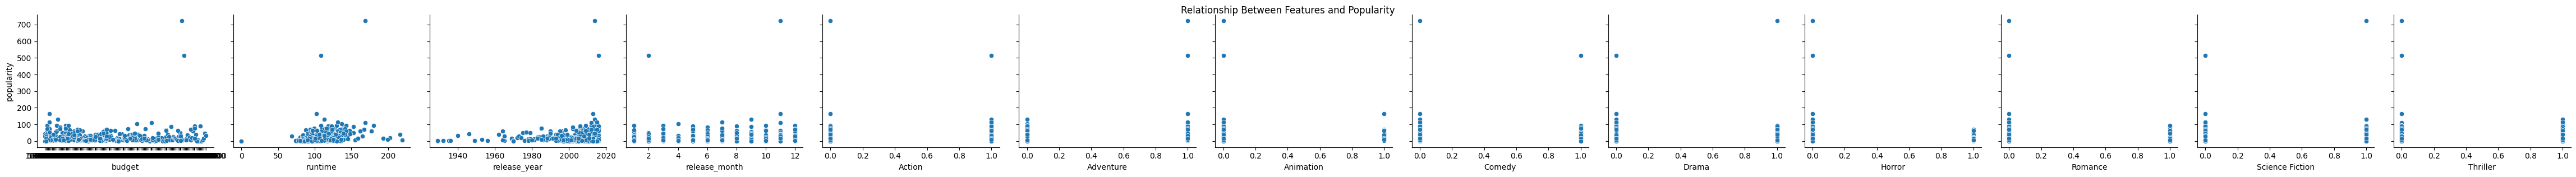

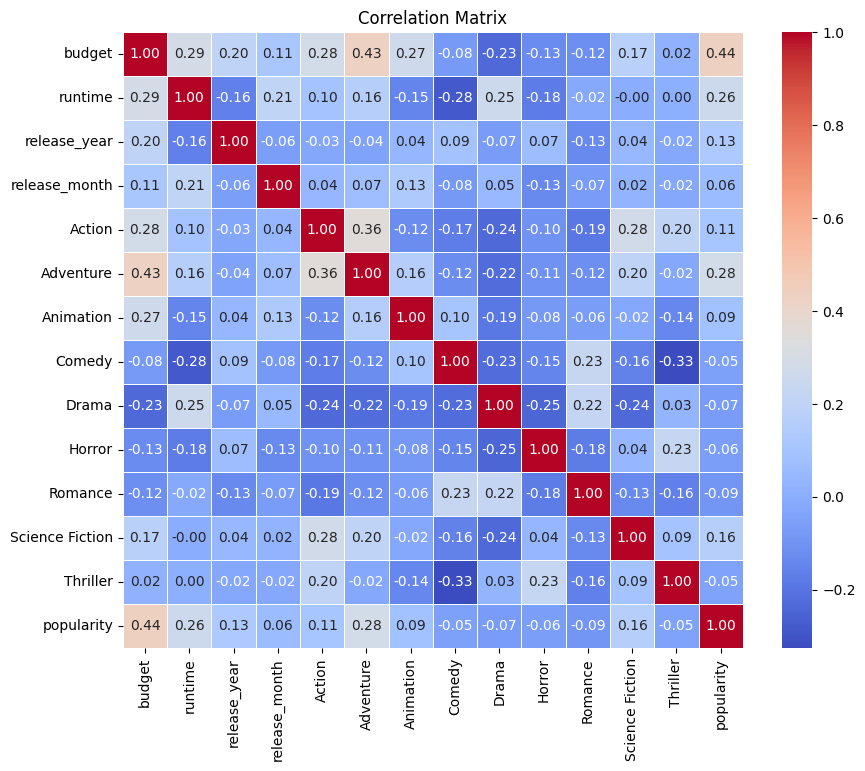

In [51]:
from sklearn.linear_model import LinearRegression

# Pipeline
lr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Parameter grid
lr_params = {
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [True, False]
}

# Grid search
lr_grid = GridSearchCV(lr_pipe, lr_params, cv=5, scoring='r2', n_jobs=-1, return_train_score=True)
lr_grid.fit(X_train, y_train)

# Results
print("Linear Regression Best Parameters:\n{}\n".format(lr_grid.best_params_))
print("Best cross-validation train score: {:.3f}".format(lr_grid.cv_results_['mean_train_score'][lr_grid.best_index_]))
print("Best cross-validation score: {:.3f}".format(lr_grid.best_score_))
print("Test R2: {:.3f}".format(lr_grid.score(X_test, y_test)))


lr_y_pred = lr_grid.predict(X_test)

data = pd.concat([X_test, y_test], axis=1)

# scatterplot of each feature vs target vector (popularity)
sns.pairplot(data, x_vars=X.columns, y_vars='popularity', height=3, aspect=1.2)
plt.suptitle("Relationship Between Features and Popularity", y=1.02)
plt.show()

corr_matrix = data.corr()

# Demonstrates how strongly each feature is correlated with the target vector
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


#### Model 2: Random Forest

Random Forest Best Parameters:
{'regressor__max_depth': 10, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}

Best cross-validation train score: 0.811
Best cross-validation score: 0.317
Test R2: 0.314


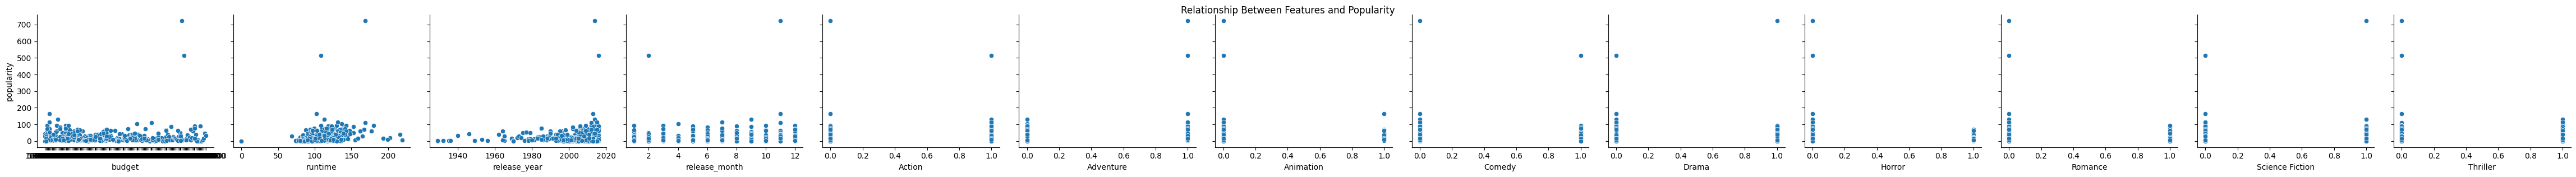

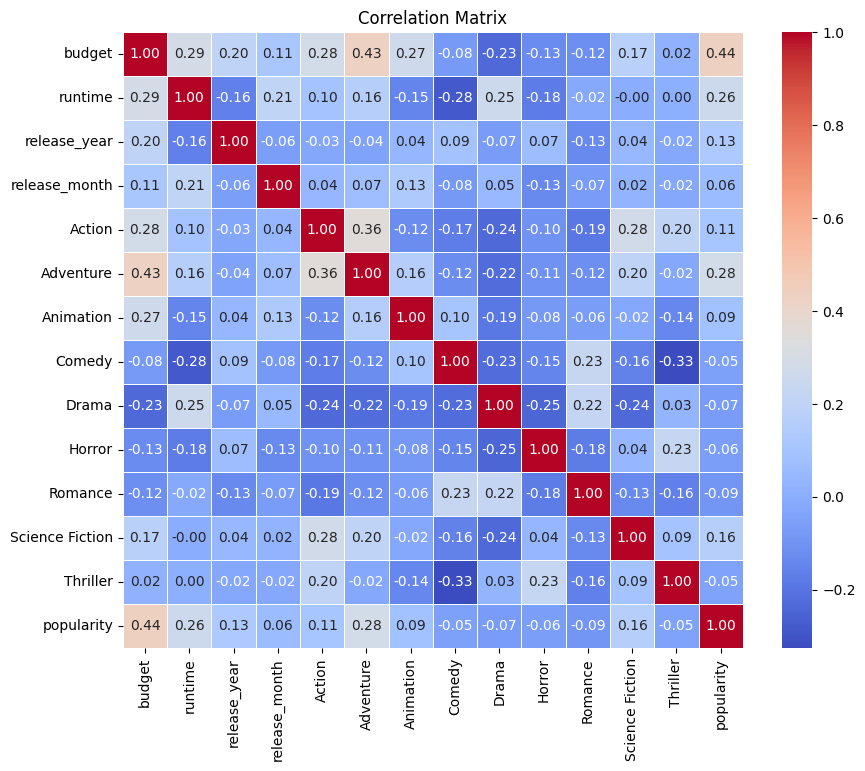

In [55]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Pipeline
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Parameter grid
rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

# Grid search
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring='r2', n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train, y_train)

# Results
print("Random Forest Best Parameters:\n{}\n".format(rf_grid.best_params_))
print("Best cross-validation train score: {:.3f}".format(rf_grid.cv_results_['mean_train_score'][rf_grid.best_index_]))
print("Best cross-validation score: {:.3f}".format(rf_grid.best_score_))
print("Test R2: {:.3f}".format(rf_grid.score(X_test, y_test)))

rf_y_pred = rf_grid.predict(X_test)

data = pd.concat([X_test, y_test], axis=1)

# scatterplot of each feature vs target vector (popularity)
sns.pairplot(data, x_vars=X.columns, y_vars='popularity', height=3, aspect=1.2)
plt.suptitle("Relationship Between Features and Popularity", y=1.02)
plt.show()

corr_matrix = data.corr()

# Demonstrates how strongly each feature is correlated with the target vector
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



#### Model 3: SVM

Random Forest Best Parameters:
{'regressor__C': 100, 'regressor__epsilon': 0.2, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}

Best cross-validation train score: 0.379
Best cross-validation score: 0.334
Test R2: 0.244


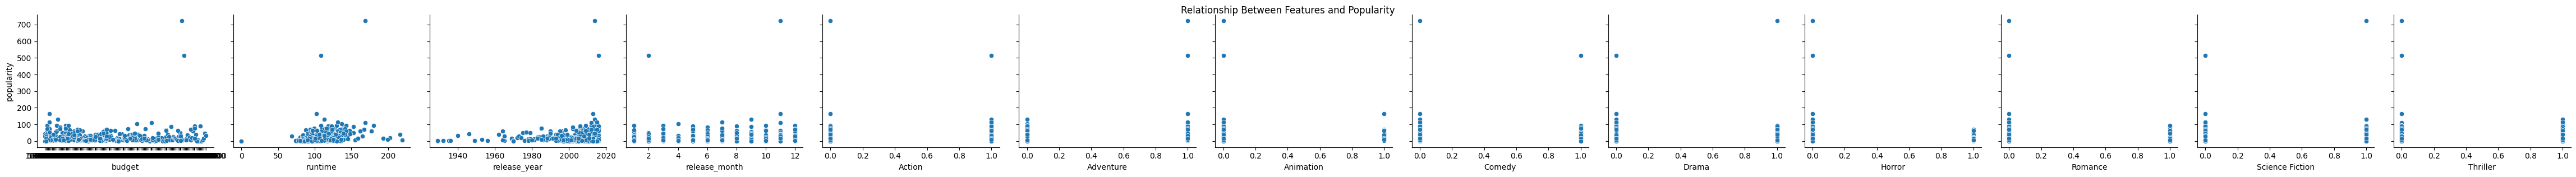

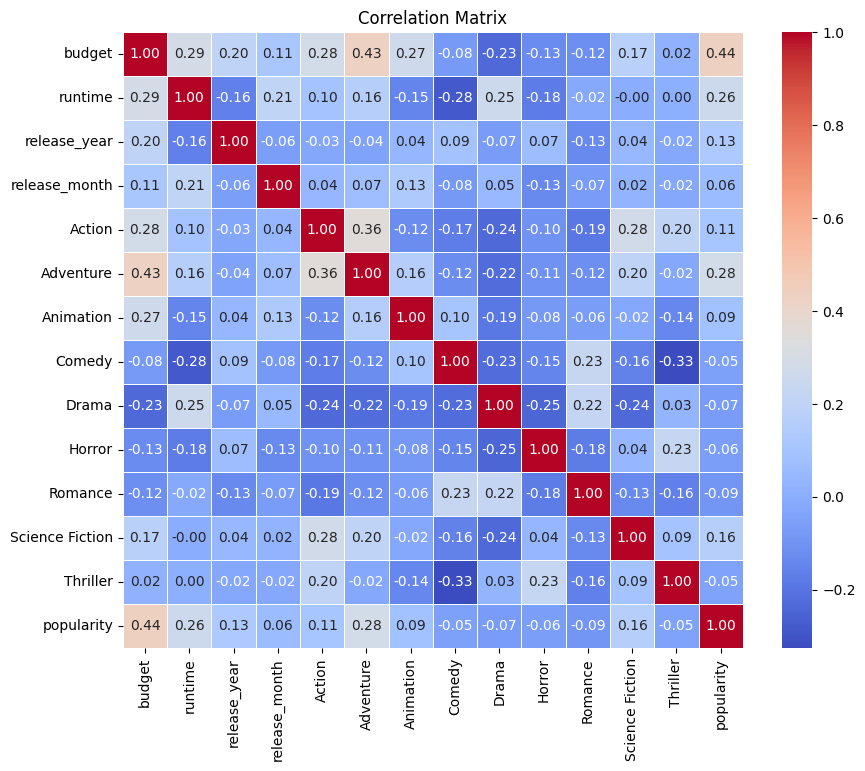

In [54]:
from sklearn.svm import SVR

# Pipeline
svr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# Parameter grid
svr_params = {
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__gamma': ['scale', 'auto', 0.01, 0.1],
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__epsilon': [0.1, 0.2]
}

# Grid search
svr_grid = GridSearchCV(svr_pipe, svr_params, cv=5, scoring='r2', n_jobs=-1, return_train_score=True)
svr_grid.fit(X_train, y_train)

# Results
print("Random Forest Best Parameters:\n{}\n".format(svr_grid.best_params_))
print("Best cross-validation train score: {:.3f}".format(svr_grid.cv_results_['mean_train_score'][svr_grid.best_index_]))
print("Best cross-validation score: {:.3f}".format(svr_grid.best_score_))
print("Test R2: {:.3f}".format(svr_grid.score(X_test, y_test)))

svr_y_pred = svr_grid.predict(X_test)

data = pd.concat([X_test, y_test], axis=1)

# scatterplot of each feature vs target vector (popularity)
sns.pairplot(data, x_vars=X.columns, y_vars='popularity', height=3, aspect=1.2)
plt.suptitle("Relationship Between Features and Popularity", y=1.02)
plt.show()

corr_matrix = data.corr()

# Demonstrates how strongly each feature is correlated with the target vector
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

#### Final Model Comparison


Model Performance Comparison:


,CV R2,Test R2,Test Root Mean Squared Error
Random Forest,0.317319,0.314009,37.565813
SVR,0.334467,0.244408,39.425503
Linear Regression,0.309808,0.203396,40.481335
SVR,0.294560,0.184268,40.964480


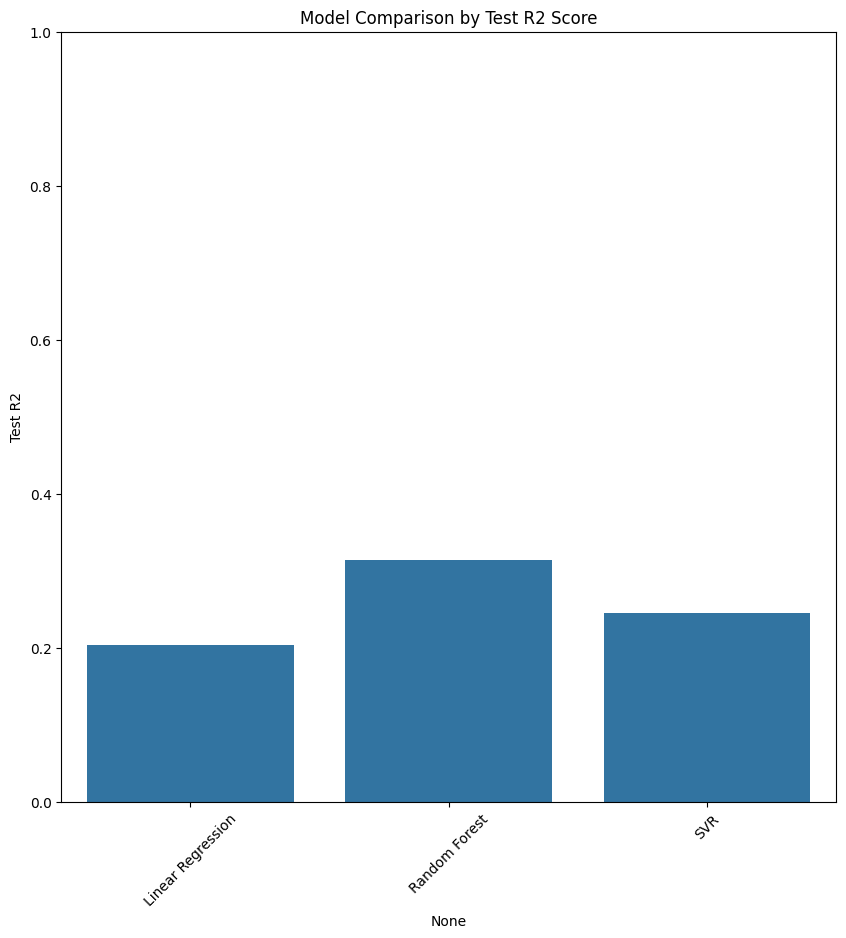

In [15]:
results = {
    'Linear Regression': {
        'CV R2': lr_grid.best_score_,
        'Test R2': r2_score(y_test, lr_y_pred),
        'Test Root Mean Squared Error': np.sqrt(mean_squared_error(y_test, lr_y_pred))
    },
    'Random Forest': {
        'CV R2': rf_grid.best_score_,
        'Test R2': r2_score(y_test, rf_y_pred),
        'Test Root Mean Squared Error': np.sqrt(mean_squared_error(y_test, rf_y_pred))
    },
    'SVR': {
        'CV R2': svr_grid.best_score_,
        'Test R2': r2_score(y_test, svr_y_pred),
        'Test Root Mean Squared Error': np.sqrt(mean_squared_error(y_test, svr_y_pred))
    }
}

# Create comparison table
comparison = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
display(comparison.sort_values('Test R2', ascending=False))

# Visualization
plt.figure(figsize=(10, 10))
sns.barplot(x=comparison.index, y='Test R2', data=comparison)
plt.title('Model Comparison by Test R2 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

Based on the results given, the random forest model provided the best results. The model yielded the highest cross validation score, along with the highest test score and lowest root mean squared error score. One thing to note was that the random forest model had a significantly higher test score when comapred to the other two models. This model captures the underlying patterns in the data better than the other two models. 